<a href="https://colab.research.google.com/github/DCunoUCF/cap4630/blob/master/HW_2_Problem_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#David Cuno
#Professor Wocjan
#CAP 4630
#11/12/19

#Problem 3

In this problem you have to work with the CIFAR10 data set. Check out the notebook cifar10_data_set to see how to load it.

Give three convolutional models that

    first model underfits
    second model overfits
    third model is pretty good

Make sure that you plot the curves depicting the training/validation accuracy/loss.

# UNDERFIT

shapes

x_train: (50000, 32, 32, 3)
y_train: (50000, 10)
x_test : (10000, 32, 32, 3)
y_test : (10000, 10)


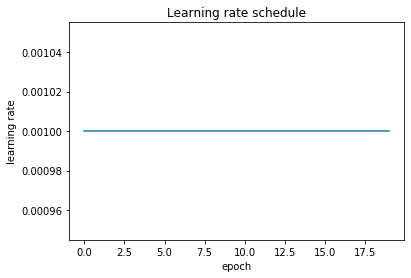

Not using data augmentation.

Epoch 00001: val_acc improved from 0.30520 to 0.45310, saving model to /content/saved_models/cifar10_ResNet20v1_model.001.h5

Epoch 00002: val_acc improved from 0.45310 to 0.60490, saving model to /content/saved_models/cifar10_ResNet20v1_model.002.h5

Epoch 00003: val_acc improved from 0.60490 to 0.64590, saving model to /content/saved_models/cifar10_ResNet20v1_model.003.h5

Epoch 00004: val_acc improved from 0.64590 to 0.67030, saving model to /content/saved_models/cifar10_ResNet20v1_model.004.h5

Epoch 00005: val_acc did not improve from 0.67030

Epoch 00006: val_acc improved from 0.67030 to 0.69140, saving model to /content/saved_models/cifar10_ResNet20v1_model.006.h5

Epoch 00007: val_acc improved from 0.69140 to 0.69550, saving model to /content/saved_models/cifar10_ResNet20v1_model.007.h5

Epoch 00008: val_acc improved from 0.69550 to 0.71400, saving model to /content/saved_models/cifar10_ResNet20v1_model.008.h5

Epoch 00009: val_acc did not improve 

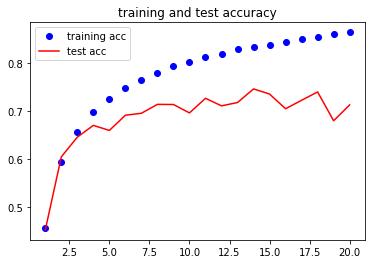

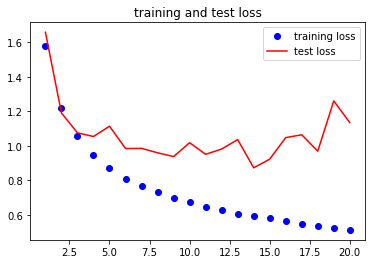

In [0]:
import keras
# data set
from keras.datasets import cifar10
# layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
# optimizers
from keras.optimizers import Adam
# callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
# data augmentation
from keras.preprocessing.image import ImageDataGenerator
# regularizers
from keras.regularizers import l2
# backend
from keras import backend as K
# model
from keras import Model
# utils
from keras.utils.vis_utils import model_to_dot
# numpy
import numpy as np
# os
import os
# IPython display
from IPython.display import SVG
# matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Training parameters
batch_size = 32
epochs = 20 # default was 200
data_augmentation = False
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
n = 3

# Model version
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Input dimensions
input_shape = x_train.shape[1:]

# Number of non-test examples
num_train = x_train.shape[0] 

# If subtract pixel mean is enabled
if subtract_pixel_mean:
  x_train_mean = np.mean(x_train, axis=0)
  x_train -= x_train_mean
  x_test -= x_train_mean

print('shapes')
print()
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test :', x_test.shape)
print('y_test :', y_test.shape)

def lr_schedule(epoch):
  """Learning Rate Schedule
  
  Learning rate is scheduled to be reduced after 100, 150, 200, 225 epochs.
  Called automatically every epoch as part of callbacks during training.
  
  # Argument
    epoch (int): The number of epochs
    
  # Returns 
    lr (float32): learning rate
  """
  
  lr = 1e-3
  
  if epoch > 180:
      lr *= 0.5e-3
  elif epoch > 160:
      lr *= 1e-3
  elif epoch > 120:
      lr *= 1e-2
  elif epoch > 80:
      lr *= 1e-1
  #print('Learning rate: ', lr)
  return lr
  
plt.title('Learning rate schedule')
plt.plot(range(epochs), [lr_schedule(epoch) for epoch in range(epochs)])
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.show()

def resnet_layer(inputs, 
                 num_filters=8, # default was 16 
                 kernel_size=3, 
                 strides=1,
                 activation='relu', 
                 batch_normalization=True, 
                 conv_first=True):
  """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
  conv = Conv2D(num_filters, 
                kernel_size=kernel_size, 
                strides=strides, 
                padding='same', 
                kernel_initializer='he_normal', 
                kernel_regularizer=l2(1e-4))  
  
  x = inputs
  if conv_first:
    # apply conv layer first
    x = conv(x)
    if batch_normalization:
      x = BatchNormalization()(x)
    if activation is not None:
      x = Activation(activation)(x)
  else:
    if batch_normalization:
      x = BatchNormalization()(x)
    if activation is not None:
      x = Activation(activation)(x)
    # apply conv layer last
    x = conv(x)
      
  return x  

def resnet_v1(input_shape, depth, num_classes):
  """ResNet Version 1 Model builder [a]

  Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
  Last ReLU is after the shortcut connection.
  At the beginning of each stage, the feature map size is halved (downsampled)
  by a convolutional layer with strides=2, while the number of filters is
  doubled. Within each stage, the layers use the same type of filters 
  (in terms of size, stride, padding) and the same number of filters.
  Features maps sizes:
  stage 0: 32x32, 16
  stage 1: 16x16, 32
  stage 2:  8x8,  64
    
  # Arguments
      input_shape (tensor): shape of input image tensor
      depth (int): number of core convolutional layers
      num_classes (int): number of classes (CIFAR10 has 10)

  # Returns
      model (Model): Keras model instance
  """
  
  if (depth - 2) % 6 != 0:
    raise ValueError('depth should be 6n+2 (eg 20, 32, 44)')
  # Start model definition
  num_filters = 8 # default was 16
  num_res_blocks = int((depth - 2) / 6)
  
  inputs = Input(shape=input_shape)
  x = resnet_layer(inputs=inputs)
  
  # Instantiate the stack of residual inputs
  for stack in range(3):
    for res_block in range(num_res_blocks):
      
      strides = 1
      if stack > 0 and res_block == 0: 
        # first layer but not first stack
        # downsample
        strides = 2 
        
      y = resnet_layer(inputs=x, 
                       num_filters=num_filters,
                       strides=strides)
      y = resnet_layer(inputs=y,
                       num_filters=num_filters,
                       activation=None)
      
      if stack > 0 and res_block == 0: 
        # first layer but not first stack
        # linear projection residual shortcut connection to match
        # changed dims
        x = resnet_layer(inputs=x,
                         num_filters=num_filters,
                         kernel_size=1,
                         strides=strides,
                         activation=None,
                         batch_normalization=False)
      x = keras.layers.add([x,y])
      x = Activation('relu')(x)
    num_filters *=2
    
  # Add classifier on top
  # v1 does not use BN after last shortcut connection-ReLU
  x = AveragePooling2D(pool_size=8)(x)
  y = Flatten()(x)
  outputs = Dense(num_classes,
                  activation='softmax',
                  kernel_initializer='he_normal')(y)
  # Instantiate model
  model = Model(inputs=inputs, outputs=outputs)
  return model

model = resnet_v1(input_shape, 20, 10)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

# Prepare model model saving directory.
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
# checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_acc',
#                              verbose=1,
#                              save_best_only=True)

# lr_scheduler = LearningRateScheduler(lr_schedule)

# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)

# callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        shuffle=True,
                        verbose=0,
                        callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                  validation_data=(x_test, y_test),
                                  shuffle=True,
                                  epochs=epochs, 
                                  steps_per_epoch=num_train // batch_size,
                                  verbose=0, 
                                  callbacks=callbacks)
    
# Score trained model.
# test
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Score trained model.
# train
scores = model.evaluate(x_train, y_train, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1])

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'r', label='test acc')
plt.title('training and test accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='test loss')
plt.title('training and test loss')
plt.legend()

plt.show()

start_epoch = 0 # default was 60

# # training and validation accuracy

# plt.plot(epochs[start_epoch:], acc[start_epoch:], 'bo', label='training acc')
# plt.plot(epochs[start_epoch:], val_acc[start_epoch:], 'r', label='validation acc')
# plt.title('training and validation accuracy')
# plt.legend()

# plt.figure()

# # training and validation loss

# plt.plot(epochs[start_epoch:], loss[start_epoch:], 'bo', label='training loss')
# plt.plot(epochs[start_epoch:], val_loss[start_epoch:], 'r', label='validation loss')
# plt.title('training and validation loss')
# plt.legend()

# plt.show()

# OVERFIT

In [0]:
import keras
# data set
from keras.datasets import cifar10
# layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
# optimizers
from keras.optimizers import Adam
# callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
# data augmentation
from keras.preprocessing.image import ImageDataGenerator
# regularizers
from keras.regularizers import l2
# backend
from keras import backend as K
# model
from keras import Model
# utils
from keras.utils.vis_utils import model_to_dot
# numpy
import numpy as np
# os
import os
# IPython display
from IPython.display import SVG
# matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Training parameters
batch_size = 32
epochs = 10 # default was 200 #################################
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
n = 3

# Model version
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Input dimensions
input_shape = x_train.shape[1:]

# Number of non-test examples
num_train = x_train.shape[0] 

# If subtract pixel mean is enabled
if subtract_pixel_mean:
  x_train_mean = np.mean(x_train, axis=0)
  x_train -= x_train_mean
  x_test -= x_train_mean

# print('shapes')
# print()
# print('x_train:', x_train.shape)
# print('y_train:', y_train.shape)
# print('x_test :', x_test.shape)
# print('y_test :', y_test.shape)

def lr_schedule(epoch):
  """Learning Rate Schedule
  
  Learning rate is scheduled to be reduced after 100, 150, 200, 225 epochs.
  Called automatically every epoch as part of callbacks during training.
  
  # Argument
    epoch (int): The number of epochs
    
  # Returns 
    lr (float32): learning rate
  """
  
  lr = 1e-1 # default was 1e-3
  
  if epoch > 180:
      lr *= 0.5e-3
  elif epoch > 160:
      lr *= 1e-3
  elif epoch > 120:
      lr *= 1e-2
  elif epoch > 80:
      lr *= 1e-1
  #print('Learning rate: ', lr)
  return lr
  
# plt.title('Learning rate schedule')
# plt.plot(range(epochs), [lr_schedule(epoch) for epoch in range(epochs)])
# plt.ylabel('learning rate')
# plt.xlabel('epoch')
# plt.show()

def resnet_layer(inputs, 
                 num_filters=16, # default was 16 ##########################
                 kernel_size=3, 
                 strides=1,
                 activation='relu', 
                 batch_normalization=True, 
                 conv_first=True):
  """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
  conv = Conv2D(num_filters, 
                kernel_size=kernel_size, 
                strides=strides, 
                padding='same', 
                kernel_initializer='he_normal', 
                kernel_regularizer=l2(1e-4))  
  
  x = inputs
  if conv_first:
    # apply conv layer first
    x = conv(x)
    if batch_normalization:
      x = BatchNormalization()(x)
    if activation is not None:
      x = Activation(activation)(x)
  else:
    if batch_normalization:
      x = BatchNormalization()(x)
    if activation is not None:
      x = Activation(activation)(x)
    # apply conv layer last
    x = conv(x)
      
  return x  

def resnet_v1(input_shape, depth, num_classes):
  """ResNet Version 1 Model builder [a]

  Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
  Last ReLU is after the shortcut connection.
  At the beginning of each stage, the feature map size is halved (downsampled)
  by a convolutional layer with strides=2, while the number of filters is
  doubled. Within each stage, the layers use the same type of filters 
  (in terms of size, stride, padding) and the same number of filters.
  Features maps sizes:
  stage 0: 32x32, 16
  stage 1: 16x16, 32
  stage 2:  8x8,  64
    
  # Arguments
      input_shape (tensor): shape of input image tensor
      depth (int): number of core convolutional layers
      num_classes (int): number of classes (CIFAR10 has 10)

  # Returns
      model (Model): Keras model instance
  """
  
  if (depth - 2) % 6 != 0:
    raise ValueError('depth should be 6n+2 (eg 20, 32, 44)')
  # Start model definition
  num_filters = 16 # default was 16 ####################################
  num_res_blocks = int((depth - 2) / 6)
  
  inputs = Input(shape=input_shape)
  x = resnet_layer(inputs=inputs)
  
  # Instantiate the stack of residual inputs
  for stack in range(3):
    for res_block in range(num_res_blocks):
      
      strides = 1
      if stack > 0 and res_block == 0: 
        # first layer but not first stack
        # downsample
        strides = 2 
        
      y = resnet_layer(inputs=x, 
                       num_filters=num_filters,
                       strides=strides)
      y = resnet_layer(inputs=y,
                       num_filters=num_filters,
                       activation=None)
      
      if stack > 0 and res_block == 0: 
        # first layer but not first stack
        # linear projection residual shortcut connection to match
        # changed dims
        x = resnet_layer(inputs=x,
                         num_filters=num_filters,
                         kernel_size=1,
                         strides=strides,
                         activation=None,
                         batch_normalization=False)
      x = keras.layers.add([x,y])
      x = Activation('relu')(x)
    num_filters *=2
    
  # Add classifier on top
  # v1 does not use BN after last shortcut connection-ReLU
  x = AveragePooling2D(pool_size=8)(x) # default was 8
  y = Flatten()(x)
  outputs = Dense(num_classes,
                  activation='softmax',
                  kernel_initializer='he_normal')(y)
  # Instantiate model
  model = Model(inputs=inputs, outputs=outputs)
  return model

model = resnet_v1(input_shape, 32, 10) # default was (..., 20, 10) ##################

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        shuffle=True,
                        verbose=0,
                        callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                  validation_data=(x_test, y_test),
                                  shuffle=True,
                                  epochs=epochs, 
                                  steps_per_epoch=num_train // batch_size,
                                  verbose=0, 
                                  callbacks=callbacks)
    
# Score trained model.
# test
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Score trained model.
# train
scores = model.evaluate(x_train, y_train, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1])

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'r', label='test acc')
plt.title('training and test accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='test loss')
plt.title('training and test loss')
plt.legend()

plt.show()

Using real-time data augmentation.

Epoch 00001: val_acc did not improve from 0.77880

Epoch 00002: val_acc did not improve from 0.77880

Epoch 00003: val_acc did not improve from 0.77880

Epoch 00004: val_acc did not improve from 0.77880

Epoch 00005: val_acc did not improve from 0.77880

Epoch 00006: val_acc did not improve from 0.77880


# PRETTY GOOD